In [1]:
import numpy as np
from scipy import io
import sys
import os
#import matplotlib.pyplot as plt
#%matplotlib inline

In [7]:
"""
import sys
sys.path.append("../portfolios")
from portfolio import Portfolio
import util
from olmar import OLMAR
from expert_pool import ExpertPool
"""

ValueError: Attempted relative import in non-package

In [28]:
mat_dict = io.loadmat('portfolio.mat')
test_cl = mat_dict['train_cl']
test_hi = mat_dict['train_hi']
test_lo = mat_dict['train_lo']
test_op = mat_dict['train_op']
test_vol = mat_dict['train_vol']
numDays, numStocks = test_cl.shape
test_stocks = []
for i in range(numStocks):
    test_stocks.append(np.array_str(mat_dict['train_stocks'][0][i])[3:-2])

In [29]:
def uniform_rebalance(t, portfolio_t, hi, lo, cl, op, stocks, vol):
    """% Input: 
    %%% t: we are at Day t
    %%% portfolio_t: current portfolio before open of Day t
    %%% hi: highest prices at Day t-1
    %%% lo: lowest prices at Day t-1
    %%% cl: close prices at Day t-1
    %%% op: open prices at Day t
    %%% stocks: names of all stocks
    %%% vol: volumes at Day t-1

    % Output: 
    %%% portfolio: a column vector, each entry represents the portion of 
    %%%            the value of the corresponding stock over the total cash 
    %%%            realizable value [as a result, the value of inactive stocks 
    %%%            i.e., with open price NaN, cannot be added into the total
    %%%            cash realizable value]. Hence, your output must satisfy
    %%%            sum(portfolio(isfinite(op))) < 1, and the rest is the 
    %%%            portion of cash realizable value you hold in cash. 
    %%% hold_flag: a binary vector representing whether you would like to hold
    %%%            (with value 1) each stock or you choose to rebalance it
    %%%            (with value 0). """
    numStocks = len(stocks)
    portfolio = np.zeros(numStocks)
    numActiveStock = np.sum(np.isfinite(op))
    portfolio[np.isfinite(op)] = 1.0/numActiveStock
    if np.mod(t,2) == 1:
        hold_flag = np.zeros(numStocks,dtype=bool)
    else:
        hold_flag = np.ones(numStocks,dtype=bool)      
    return portfolio

In [30]:
def rebalance(value_vec, value_realizable, portfolio_dst, cost_rate):
    """ % This function simulates the process of rebalancing. The key difficulty 
    % here is to compute the transaction cost, i.e., to solve the equation
    %
    % sum( cost_rate * abs( portfolio_dst .* (value_realizable - C) -
    % value_vec) ) = C
    % 
    % where C is the total transcation cost. We use the Banach contraction 
    % theorem to solve this equation, with convergence rate cost_rate^t for 
    % t-th iteration. 

    % Input: 
    %%% value_vec: current values of each active stock
    %%% value_realizable: total cash realizable value
    %%% portfolio_dst: the desired portfolio after rebalancing
    %%% cost_rate: ratio of transactions cost (0.0005 in our case)

    % Output:
    %%% new_value_vec: the value vector after rebalancing
    %%% trans_cost: the total transaction cost"""
    
    iter_num = 7
    trans_cost = 0
    for iter in range(iter_num):
        trans_cost = np.sum(cost_rate * np.abs(portfolio_dst * \
                        (value_realizable-trans_cost)-value_vec))
        
    new_value_vec = portfolio_dst * (value_realizable - trans_cost)
    return new_value_vec, trans_cost

In [31]:
value_op_seq = np.zeros(numDays) # total value before open of each day
value_cl_seq = np.zeros(numDays) # total value before close of each day 
portfolio_seq = np.zeros((numStocks, numDays)) # portfolio before open of each day
last_close_price = np.NaN * np.ones(numStocks)
print numDays, numStocks

1247 497


In [32]:
# Initialization
op = test_op[0,:]
cl = np.NaN * np.ones(numStocks)
hi = np.NaN * np.ones(numStocks)
lo = np.NaN * np.ones(numStocks)
vol = np.NaN * np.ones(numStocks)
value_op_seq[0] = 1 # initially we hvae one unit of cash

In [33]:
"""
import util
from olmar import OLMAR
import market_data
from expert_pool import ExpertPool
"""
# Package data into a Market Data object

data = util.load_matlab_sp500_data('portfolio.mat')

# Initialize portfolio optimization class
olmar = OLMAR(market_data=data, tune_interval=None, verbose=False)
olmar2 = OLMAR(market_data = data, tune_interval = 100, verbose=False)
pool = ExpertPool(market_data=data, experts=[olmar, olmar2], weighting_strategy='exp_window', windows=[5])
pool.run()
portfolios = pool.b_history
portfolios = np.asarray(portfolios)
# portfolios = np.load('b_history.npy')

for t in range(numDays):
    # At the beginning of day t, we use all information up to the open 
    # price of day t to determine the capital allocation at the end of 
    # day t.
    
    # Your function should be placed here. Note that the input vector may
    # contain NaNs (at Day 1, or for some inactive stocks). 
    #new_portfolio, hold_flag = uniform_rebalance(t, portfolio_seq[:,t], hi, lo, cl, op, test_stocks, vol)
    
#     if(t < numDays-1):
    hold_flag = np.zeros(numStocks,dtype=bool)
    new_portfolio = portfolios[:,t]
#     else:
#         hold_flag = np.ones(numStocks,dtype=bool)   
    
    # Check whether your output is valid
    isActive = np.isfinite(op)
    noHold = np.logical_and(isActive, np.logical_not(hold_flag))
    if np.sum(new_portfolio[noHold]) > 1 + 1e-6: #1e-8:
        sys.stderr.write('The output portfolio is not valid!')
        
    # The value of our portfolio at the end of Day t before paying transaction costs
    cl = test_cl[t,:]
    value_vec = value_op_seq[t] * portfolio_seq[:,t]
    growth = cl[isActive] / last_close_price[isActive]-1
    growth[np.isnan(growth)] = 0
    revenue_vec = value_vec[isActive] * growth
    value_vec[isActive] = value_vec[isActive] + revenue_vec
    value_cl_seq[t] = value_op_seq[t] + np.sum(revenue_vec)
        

    # At the end of Day t, we use the close price of day t to adjust our 
    # portfolio to the desired percentage.
    if t <= numDays-2:
        nonActive = np.logical_not(isActive)
        value_realizable = value_cl_seq[t] - np.sum(value_vec[nonActive])
        new_value_vec, trans_cost = rebalance(value_vec[isActive], value_realizable, \
                                              new_portfolio[isActive], 0.0005)
        value_op_seq[t+1] = value_cl_seq[t] - trans_cost
        value_vec[isActive] = new_value_vec
        portfolio_seq[:,t+1] = value_vec / value_op_seq[t+1]
        
    last_close_price[isActive] = cl[isActive]
    
    # Update information
    if t <= numDays-2:
        op = test_op[t+1,:]
        hi = test_op[t,:]
        lo = test_lo[t,:]
        vol = test_vol[t,:]

AttributeError: 'module' object has no attribute 'rebalance'

0.133913890443 0.977325726772


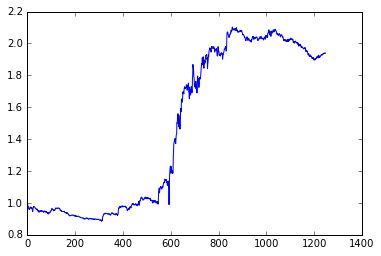

In [32]:
#plt.plot(value_op_seq)
return_seq = np.log(value_op_seq[1:] / value_op_seq[:-1])
annual_return = 252 * np.mean(return_seq)
sharpe = np.sqrt(252) * np.mean(return_seq) / np.std(return_seq)
print annual_return, sharpe

In [24]:
np.mod(3,2)

1

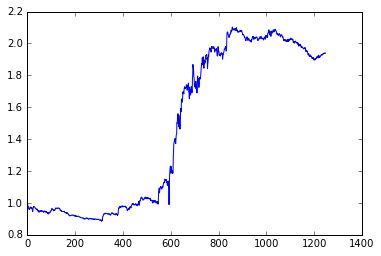

In [49]:
experts_dollars_history = np.array([[ 0.96956117,  0.97416693,  0.973153  ,  0.96998448,  0.97038573],
       [ 0.92430382,  0.92361105,  0.92315414,  0.9327521 ,  0.93862142]])
for i, dollars_history in enumerate(experts_dollars_history):
            prev_window_start = 0
            for (w, window) in enumerate([[windows]]):
                window_start = 0
                if w == 0:
                    window_stop = 5
                else:
                    window_stop = prev_window_start
                window_dollars = dollars_history[window_start:window_stop]

                # Perform Exponential Weighting and Scale Down Older Windows
                scale = (1.0 * self.ew_alpha)**w
                cum_sharpes[0, i] += scale * exp(self.ew_eta * util.empirical_sharpe_ratio(window_dollars))
                prev_window_start = window_start

        # Normalize to obtain weights that sum to 1
        weights = (1.0 / np.sum(cum_sharpes)) * cum_sharpes

In [4]:
f_path = '../train_results/train1.txt'
arr = np.loadtxt(f_path)

In [5]:
print arr

[ 1.  2.  3.]


In [8]:
out_fpath = '../train_results/OLMAR/dollars_history_train.txt'
dollars_hist_tr = np.zeros(10)
for i in range(10):
    dollars_hist_tr[i] = i
out_f = open(out_fpath, 'w')
header = 'History of wealth held by OLMAR portfolio over time\n ABCD'
np.savetxt(out_fpath, dollars_hist_tr, delimiter='\t', header=header)

In [3]:
out_file = 'test_out.txt'
fo = open(out_file, 'w')
li = [1, 2, 3]
str1 ='Epsilon\t' + '\t'.join([str(val) for val in li])
print str1
fo.write(str1 + '\n')
fo.close()

Epsilon	1	2	3


In [5]:
fo = open(out_file)
for line in fo:
    vals = line.rstrip().split('\t')
    print vals

['Epsilon', '1', '2', '3']


In [19]:
arr2 = np.loadtxt(out_file, usecols=(1,))
print arr2

1.0


In [21]:
x, y, z = None, None, None

In [34]:
dic = {'a':1, 'b':2, 'aa':4}
for key, val in dic.iteritems():
    print key, val

a 1
aa 4
b 2


In [ ]:
      #str1 ='Epsilon\t' + '\t'.join([str(val) for val in li])

In [39]:
class a:
    def __init__(self):
        self.x = 'x'
        
    def test(self):
        print self.x
        if hasattr(self, 'x'):
            print 'hi'
        
A = a()
A.test()

x
hi
